In [184]:
# グラフ描画系
import matplotlib
from matplotlib import font_manager
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import rc
from matplotlib_venn import venn2, venn2_circles
from matplotlib import animation as ani
from IPython.display import Image

plt.rcParams["patch.force_edgecolor"] = True
#rc('text', usetex=True)
from IPython.display import display # Allows the use of display() for DataFrames
import seaborn as sns
sns.set(style="whitegrid", palette="muted", color_codes=True)
sns.set_style("whitegrid", {'grid.linestyle': '--'})
red = sns.xkcd_rgb["light red"]
green = sns.xkcd_rgb["medium green"]
blue = sns.xkcd_rgb["denim blue"]

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [185]:
import gc
from pathlib import Path
import numpy as np
import pandas as pd
import datetime
from time import time
from tqdm import tqdm_notebook as tqdm
import lightgbm as lgb
from collections import Counter
from collections import defaultdict
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, cohen_kappa_score

#  pandas setting
pd.set_option("display.max_colwidth", 100)
# pd.set_option("display.max_rows", None)
# pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 100)
pd.options.display.float_format = '{:,.5f}'.format

In [186]:
###################################
def unpickle(filename):
    with open(filename, 'rb') as fo:
        p = pickle.load(fo)
    return p

def to_pickle(filename, obj):
    with open(filename, 'wb') as f:
        pickle.dump(obj, f, -1)
        
class ModelExtractionCallback(object):
    """Callback class for retrieving trained model from lightgbm.cv()
    NOTE: This class depends on '_CVBooster' which is hidden class, so it might doesn't work if the specification is changed.
    from: https://blog.amedama.jp/entry/2019/08/14/235421
    """

    def __init__(self):
        self._model = None

    def __call__(self, env):
        # Saving _CVBooster object.
        self._model = env.model

    def _assert_called_cb(self):
        if self._model is None:
            # Throw exception if the callback class is not called.
            raise RuntimeError('callback has not called yet')

    @property
    def boosters_proxy(self):
        self._assert_called_cb()
        # return Booster object
        return self._model

    @property
    def raw_boosters(self):
        self._assert_called_cb()
        # return list of Booster
        return self._model.boosters

    @property
    def best_iteration(self):
        self._assert_called_cb()
        # return boosting round when early stopping.
        return self._model.best_iteration
    
def check_gpu_available():
    try:
        import torch
        return torch.cuda.is_available()
    except Exception as e:
        print(e)
        return False
    
class GBDTWrapper(object):

    def __init__(self, seed=71):
        self.param = {}
        self.fold_seed = 0
        self.seed = seed
        self.use_gpu = check_gpu_available()

    def calc_score(self, score_type, target, oof):
        if score_type == "auc":
            score = roc_auc_score(target, oof)
            print(f"auc on oof preds: {score}")
        elif score_type == "rmse":
            score = np.sqrt(mean_squared_error(target, oof))
            print(f"rmse on oof preds: {score}")
            
        elif score_type == "mae":
            score = mean_absolute_error(target, oof)
            print(f"mae on oof preds: {score}")
        else:
            raise NotImplementedError
        return score

    @property
    def seed(self):
        return self.seed

    @seed.setter
    def seed(self, value):
        self.param["seed"] = value
        self.param["bagging_seed"] = value + 1
        self.param["feature_fraction_seed"] = value + 2
        self.param["drop_seed"] = value + 3
        self.fold_seed = value + 4

    def rank_average(self, preds):
        ranked_pred = rankdata(preds)
        return (ranked_pred - np.min(ranked_pred)) / (np.max(ranked_pred) - np.min(ranked_pred))

class LightGBMWrapper(GBDTWrapper):

    def __init__(self, train:pd.DataFrame,
                 target:list,
                 param:dict,
                 test:pd.DataFrame = None,
                 stratified:bool=False,
                 kfold_shuffle:bool=False,
                 fold_num:int=5,
                 fold_type:str="kfold",
                 group=None,
                 early_stopping_rounds:int=None,
                 categorical_features:list=[],
                 rank_ave:bool=False,
                 base_oof:list=None,
                 seed:int=71,
                 verbose_eval=100,
                 last_gs_idx=None):
        super(LightGBMWrapper, self).__init__(seed=seed)
        self.param:dict = param
        self.train:pd.DataFrame = train
        self.test:pd.DataFrame = test
        self.target:list = target
        self.rank_ave:bool = rank_ave
        self.categorical_features:list = categorical_features
        self.fold_type:str = fold_type
        assert fold_type in ["kfold", "stratified", "group"]
        self.kfold_shuffle:bool = kfold_shuffle
        self.early_stopping_rounds:int = early_stopping_rounds
        self.base_oof = base_oof
        self.verbose_eval:bool = verbose_eval
        self.ret_dict:dict = {}
        self.models:list = []
        self.group = group
        self.fold_num:int=fold_num
        self.seed = seed
        if last_gs_idx:
            self.last_gs_idx = last_gs_idx
        else:
            self.last_gs_idx = [i for i in range(len(train))]
        
    def fit_predict_cv(self):
        lgb_train = lgb.Dataset(self.train, self.target, init_score=self.base_oof)

        extraction_cb = ModelExtractionCallback()
        callbacks = [extraction_cb]
        print(self.param)

        if self.fold_type == "stratified":
            folds = StratifiedKFold(n_splits=self.fold_num, shuffle=True, random_state=self.fold_seed)
        elif self.fold_type == "kfold":
            folds = KFold(n_splits=self.fold_num, shuffle=self.kfold_shuffle, random_state=self.fold_seed)
        elif self.fold_type == "group":
            assert self.group is not None
            folds = GroupKFold(n_splits=self.fold_num)
            fold_iter = folds.split(self.train, self.target, groups=self.group)
            split_list = []
            for n_fold, (trn_idx, val_idx) in enumerate(fold_iter):
                val_idx = [idx for idx in val_idx if idx in self.last_gs_idx]
                split_list.append([trn_idx, val_idx])
            folds = split_list 
        else:
            assert False

        history = lgb.cv(params=self.param,
                         train_set=lgb_train,
                         categorical_feature=self.categorical_features,
                         folds=folds,
                         verbose_eval=self.verbose_eval,
                         early_stopping_rounds=self.early_stopping_rounds,
                         callbacks=callbacks,
                         )

        boosters = extraction_cb.raw_boosters
        self.models = boosters
        self.best_iteration = extraction_cb.best_iteration

        importance_df = pd.DataFrame([b.feature_importance(importance_type="gain") for b in boosters]).T
        importance_df.index = self.train.columns
        importance_df["ave"] = importance_df.mean(axis=1)
        importance_df.sort_values("ave", ascending=False, inplace=True)

        if self.fold_type != "group":
            fold_iter = folds.split(self.train, self.target)
        else:
            fold_iter = folds
        val_index_list = []
        oof_list = []
        for n_fold, ((trn_idx, val_idx), booster) in enumerate(zip(fold_iter, boosters)):
            val_idx = [idx for idx in val_idx if idx in self.last_gs_idx]
            valid = self.train.iloc[val_idx]
            oof = booster.predict(valid, num_iteration=self.best_iteration)
            if self.rank_ave:
                oof = self.rank_average(oof)
            oof_list += [oof]
            val_index_list += [val_idx]

        val_index = np.argsort(np.concatenate(val_index_list))
        oof_preds = np.concatenate(oof_list)

        score = self.calc_score("rmse", self.target[self.last_gs_idx], oof_preds[val_index])
        # score = self.calc_score("rmse", self.target, oof_preds[val_index])

        self.ret_dict = {}
        self.ret_dict["oof_preds"] = oof_preds[val_index]
        self.ret_dict["auc_score"] = score
        self.ret_dict["history"] = history
        self.ret_dict["importance_df"] = importance_df
        
        # Predicting with test data of each CV separately.
        if self.test is not None:
            predict()
            
        return self.ret_dict
    
    def predict(self):
            y_preds = np.zeros((self.test.shape[0], self.fold_num))
            for i, booster in enumerate(self.models):
                y_preds[:, i] = booster.predict(self.test, num_iteration=self.best_iteration)
                if self.rank_ave:
                    y_preds[:, i] = self.rank_average(y_preds[:, i])
            y_preds = np.mean(y_preds, axis=1)
            if self.rank_ave:
                oof_preds = self.rank_average(oof_preds)
                y_preds = self.rank_average(y_preds)
            self.ret_dict["y_preds"] = y_preds
            

clip_time = {'Welcome to Lost Lagoon!':19,'Tree Top City - Level 1':17,'Ordering Spheres':61, 'Costume Box':61,
        '12 Monkeys':109,'Tree Top City - Level 2':25, 'Pirate\'s Tale':80, 'Treasure Map':156,'Tree Top City - Level 3':26,
        'Rulers':126, 'Magma Peak - Level 1':20, 'Slop Problem':60, 'Magma Peak - Level 2':22, 'Crystal Caves - Level 1':18,
        'Balancing Act':72, 'Lifting Heavy Things':118,'Crystal Caves - Level 2':24, 'Honey Cake':142, 'Crystal Caves - Level 3':19,
        'Heavy, Heavier, Heaviest':61}

# this is the function that convert the raw data into processed features
def get_data(user_sample, test_set=False):
    '''
    The user_sample is a DataFrame from train or test where the only one 
    installation_id is filtered
    And the test_set parameter is related with the labels processing, that is only requered
    if test_set=False
    '''
    # Constants and parameters declaration
    last_activity = 0
    user_activities_count = {'Clip':0, 'Activity': 0, 'Assessment': 0, 'Game':0}
        
    # news features: time spent in each activity
    time_spent_each_act = {actv: 0 for actv in list_of_user_activities} # added
    # event_code_count = {eve: 0 for eve in list_of_event_code} # added
    last_session_time_sec = 0 # added
    
    accuracy_groups = {0:0, 1:0, 2:0, 3:0}
    all_assessments = []
    clip_durations = []
    accumulated_accuracy_group = 0
    accumulated_accuracy=0
    accumulated_correct_attempts = 0 
    accumulated_uncorrect_attempts = 0 
    accumulated_actions = 0
    counter = 0
    accumulated_correct = 0
    accumulated_net_correct = 0
    accumu_asses_correct = 0
    accumu_asses_net_correct = 0
    max_level = 0
    Activity_mean_event_count = 0
    Game_mean_event_count = 0
    
    mean_game_round = 0
    event_dict_all = {}
    missed_features = defaultdict(int)
    
    event_id_count: Dict[str, int] = {eve: 0 for eve in list_of_event_id}
    last_accuracy_title = {'acc_' + activities_labels[title]: -1 for title in assess_titles}
    
    event_code_first_char = {"head_code_2":0, "head_code_3":0, "head_code_4":0, "head_code_5":0}
    title_count = {eve: 0 for eve in activities_labels.values()} 
    
    time_first_activity = float(user_sample['timestamp'].values[0]) # added
    title_event_code_count = {t_eve: 0 for t_eve in all_title_event_code}
    event_code_count: Dict[str, int] = {ev: 0 for ev in list_of_event_code}
        
    durations = []
    game_durations = []
    activity_durations = []
    session_inst_id = user_sample.iloc[0].installation_id 
    # itarates through each session of one instalation_id
    session_count = 0
    for i, session in user_sample.groupby('game_session', sort=False):
        session_count += 1
        # i = game_session_id
        # session is a DataFrame that contain only one game_session
        
        # get some sessions information
        user_activities_count["inst_game_id"] = session_inst_id + "_" + session['game_session'].iloc[0]
         
        session_type = session['type'].iloc[0]
        session_title = session['title'].iloc[0]
        session_title_text = activities_labels[session_title]
            
        # get current session time in seconds
        if session_type != 'Assessment': # added
            time_spent = int(session['game_time'].iloc[-1] / 1000) # added
            time_spent_each_act[activities_labels[session_title]] += time_spent # added
            
        if (session_type == 'Activity'):
            activity_durations += [(session.iloc[-1, 2] - session.iloc[0, 2] ).seconds]
            Activity_mean_event_count = (Activity_mean_event_count + session['event_count'].iloc[-1])/2.0
            
        if (session_type == 'Game'):
            game_durations += [(session.iloc[-1, 2] - session.iloc[0, 2] ).seconds]
            Game_mean_event_count = (Game_mean_event_count + session['event_count'].iloc[-1])/2.0
            
            correct_ans = session["correct"]
            if len(session["correct"].dropna()) > 0: # correct_ans is not np.nan
                accumulated_net_correct += session["correct"].sum() 
                correct_cnt = session["correct"].value_counts()
                if 1.0 in correct_cnt.to_dict().keys():
                    accumulated_correct += correct_cnt.loc[1.0]
                    
        if session_type == 'Clip':
            clip_durations.append((clip_time[activities_labels[session_title]]))
            
            
        if len(session["level"].dropna()) > 0: # correct_ans is not np.nan
            max_level = np.max([session["level"].max(), max_level])
                
                
        try:
            game_round = json.loads(session['event_data'].iloc[-1])["round"]
            mean_game_round =  (mean_game_round + game_round)/2.0
        except:
            pass
        
        # for each assessment, and only this kind off session, the features below are processed
        # and a register are generated
        if (session_type == 'Assessment') & (test_set or len(session)>1):
            # search for event_code 4100, that represents the assessments trial
            all_attempts = session.query(f'event_code == {win_code[session_title]}')
            # then, check the numbers of wins and the number of losses
            true_attempts = all_attempts['event_data'].str.contains('true').sum()
            false_attempts = all_attempts['event_data'].str.contains('false').sum()
            # copy a dict to use as feature template, it's initialized with some itens: 
            # {'Clip':0, 'Activity': 0, 'Assessment': 0, 'Game':0}
            features = user_activities_count.copy()
            features['game_session'] = i
            
            features.update(time_spent_each_act.copy()) # added
            features.update(event_code_count.copy()) # added
            features.update(event_code_first_char.copy())
            features.update(event_dict_all.copy())
            features.update(missed_features.copy())
            features.update(title_event_code_count.copy())
            features.update(last_accuracy_title.copy())
            features.update(event_id_count.copy())
            features.update(title_count.copy())
            
            
            variety_features = [('var_event_code', event_code_count),
                               ('var_event_id', event_id_count),
                               ('var_title', title_count),
                               ('var_title_event_code', title_event_code_count)]
            for name, dict_counts in variety_features:
                arr = np.array(list(dict_counts.values()))
                features[name] = np.count_nonzero(arr)
                
            
            features['min_hour'] = session["hour"].iloc[0]
            features['accumulated_net_correct'] = accumulated_net_correct
            features['accumulated_correct'] = accumulated_correct
            features['max_level'] = max_level
            
            features['Game_mean_event_count'] = Game_mean_event_count
            features['Activity_mean_event_count'] = Activity_mean_event_count
            features['mean_game_round'] = mean_game_round
            features['accumu_asses_correct'] = accumu_asses_correct
            features['accumu_asses_net_correct'] = accumu_asses_net_correct

            # add title as feature, remembering that title represents the name of the game
            features['session_title'] = session['title'].iloc[0] 
            # the 4 lines below add the feature of the history of the trials of this player
            # this is based on the all time attempts so far, at the moment of this assessment
            features['accumulated_correct_attempts'] = accumulated_correct_attempts
            features['accumulated_uncorrect_attempts'] = accumulated_uncorrect_attempts
            accumulated_correct_attempts += true_attempts 
            accumulated_uncorrect_attempts += false_attempts
            # the time spent in the app so far
            if durations == []:
                features['duration_mean'] = 0
                features['duration_std'] = 0
            else:
                features['duration_mean'] = np.mean(durations)
                features['duration_std'] = np.std(durations)
                
            if activity_durations == []:
                features['activity_duration_mean'] = 0
                features['activity_duration_std'] = 0
            else:
                features['activity_duration_mean'] = np.mean(activity_durations)
                features['activity_duration_std'] = np.std(activity_durations)
                
            if game_durations == []:
                features['game_duration_mean'] = 0
                features['game_duration_std'] = 0
            else:
                features['game_duration_mean'] = np.mean(game_durations)
                features['game_duration_std'] = np.std(game_durations)

            if clip_durations == []:
                features['Clip_duration_mean'] = 0
                features['Clip_duration_std'] = 0
            else:
                features['Clip_duration_mean'] = np.mean(clip_durations)
                features['Clip_duration_std'] = np.std(clip_durations)
                
            durations.append((session.iloc[-1, 2] - session.iloc[0, 2] ).seconds)
            # the accurace is the all time wins divided by the all time attempts
            features['accumulated_accuracy'] = accumulated_accuracy/counter if counter > 0 else 0
            accuracy = true_attempts/(true_attempts+false_attempts) if (true_attempts+false_attempts) != 0 else 0
            accumulated_accuracy += accuracy
            last_accuracy_title['acc_' + session_title_text] = accuracy
            # a feature of the current accuracy categorized
            # it is a counter of how many times this player was in each accuracy group
            if accuracy == 0:
                features['accuracy_group'] = 0
            elif accuracy == 1:
                features['accuracy_group'] = 3
            elif accuracy == 0.5:
                features['accuracy_group'] = 2
            else:
                features['accuracy_group'] = 1
            features.update(accuracy_groups)
            accuracy_groups[features['accuracy_group']] += 1
            # mean of the all accuracy groups of this player
            features['accumulated_accuracy_group'] = accumulated_accuracy_group/counter if counter > 0 else 0
            accumulated_accuracy_group += features['accuracy_group']
            # how many actions the player has done so far, it is initialized as 0 and updated some lines below
            features['accumulated_actions'] = accumulated_actions
            # there are some conditions to allow this features to be inserted in the datasets
            # if it's a test set, all sessions belong to the final dataset
            # it it's a train, needs to be passed throught this clausule: session.query(f'event_code == {win_code[session_title]}')
            # that means, must exist an event_code 4100 or 4110
            
            features['session_count'] = session_count
            
            if test_set:
                all_assessments.append(features)
            elif true_attempts+false_attempts > 0:
                all_assessments.append(features)
                
            counter += 1

        def update_counters(counter: dict, col: str):
                num_of_session_count = Counter(session[col])
                for k in num_of_session_count.keys():
                    x = k
                    if col == 'title':
                        x = activities_labels[k]
                    counter[x] += num_of_session_count[k]
                return counter
            
        event_id_count = update_counters(event_id_count, "event_id")
        
        
        
        miss_df = session[session.event_id.isin(event_list_with_misses)]
        if len(miss_df)>0:
            misses_data = pd.DataFrame(miss_df.event_data.apply(lambda x: json.loads(x)).values.tolist())["misses"]
            missed_features["misses_mean"] += misses_data.mean()
            missed_features["misses_std"] += misses_data.std()
            missed_features["misses_max"] = np.max([missed_features["misses_max"] , misses_data.max()])
            
        if (session_type == 'Assessment'):
            correct_ans = session["correct"]
            if len(session["correct"].dropna()) > 0: # correct_ans is not np.nan
                accumu_asses_net_correct += session["correct"].sum() 
                correct_cnt = session["correct"].value_counts()
                if 1.0 in correct_cnt.to_dict().keys():
                    accumu_asses_correct += correct_cnt.loc[1.0]
                    
        event_dict = session.event_code.value_counts().to_dict()
        for k in  event_dict.keys():
            key_name = f"{session_title}_{k}_count"
            if key_name in event_dict_all.keys():
                event_dict_all[key_name] += event_dict[k]
            else:
                event_dict_all[key_name] = event_dict[k]
                
        # this piece counts how many actions was made in each event_code so far
#         n_of_event_codes = Counter(session['event_code']) # added
#         for key in n_of_event_codes.keys(): # added
#             event_code_count[key] += n_of_event_codes[key] # added

        n_of_event_head_codes = Counter(session['event_head_code']) # added
        for key in n_of_event_head_codes.keys(): # added
            event_code_first_char[f"head_code_{key}"] += n_of_event_head_codes[key] # added

        # counts how many actions the player has done so far, used in the feature of the same name
        accumulated_actions += len(session)
        if last_activity != session_type:
            user_activities_count[session_type] += 1
            last_activitiy = session_type
    # if it't the test_set, only the last assessment must be predicted, the previous are scraped
    if test_set:
        return all_assessments[-1]
    # in the train_set, all assessments goes to the dataset
    return all_assessments

def adjust_preds(y_preds):
    y_preds = np.round(y_preds).astype(int) 
    y_preds = np.where(y_preds<=0, 0, y_preds)
    return np.where(y_preds>=3, 3, y_preds)

In [187]:
def train_reducer(train):
    gr = train.groupby("installation_id").apply(lambda d: "Assessment" in d["type"].values)
    assessment_inst_id = gr[gr.values].index.values
    return train[train.installation_id.isin(assessment_inst_id)].reset_index(drop=True)


In [188]:
###################################
if Path("/kaggle").exists():
    print("====== [KAGGLE KERNEL] ======")
    LOCAL = False
    SUBMIT_PATH = Path("./")
    INPUT_PATH = Path("/kaggle/input/data-science-bowl-2019/")
else:
    print("====== [LOCAL] ======")
    LOCAL = True
    # INPUT_PATH = Path("../input/data-science-bowl-2019/")
    # SUBMIT_PATH = Path("../submit/v074")
    INPUT_PATH = Path("../mnt/inputs/origin/")
    SUBMIT_PATH = Path("../mnt/submissions/")
    SUBMIT_PATH.mkdir(parents=True, exist_ok=True)
    
DEBUG = False
if DEBUG:
    print(f"========== [DEBUG] ==========")
    nrows = 50000
else:
    nrows = None

train = pd.read_csv(INPUT_PATH/'train.csv', nrows=nrows)
specs = pd.read_csv(INPUT_PATH/'specs.csv')
test = pd.read_csv(INPUT_PATH/'test.csv', nrows=nrows)
submission = pd.read_csv(INPUT_PATH/'sample_submission.csv')
train_labels = pd.read_csv(INPUT_PATH/'train_labels.csv')

train = train_reducer(train)
print(f"train: {train.shape}")
print(f"{train.installation_id.nunique()}")

====== [LOCAL] ======
train: (8294138, 11)
4242


In [189]:
import json
def get_correct(x):
    json_data = json.loads(x)
    ret = {}
    if "correct" in json_data.keys():
        ret["correct"] = 1 if json_data["correct"] else -1
    else:
        ret["correct"] = np.nan
        
    
    if "level" in json_data.keys():
        ret["level"] = json_data["level"]
    else:
        ret["level"] = np.nan
    
    return ret

train_json =  pd.DataFrame(train.event_data.apply(get_correct).values.tolist())
test_json = pd.DataFrame(test.event_data.apply(get_correct).values.tolist())
train = pd.concat([train, train_json], axis=1)
test = pd.concat([test, test_json], axis=1)

# event_head_code feature
train["event_head_code"] = train.event_code.astype(str).str[0].astype(int)
test["event_head_code"] = test.event_code.astype(str).str[0].astype(int)

In [190]:
# encode title
# make a list with all the unique 'titles' from the train and test set
list_of_user_activities = list(set(train['title'].value_counts().index).union(set(test['title'].value_counts().index)))

# make a list with all the unique 'event_code' from the train and test set
list_of_event_code = list(set(train['event_code'].value_counts().index).union(set(test['event_code'].value_counts().index)))

# create a dictionary numerating the titles
activities_map = dict(zip(list_of_user_activities, np.arange(len(list_of_user_activities))))
activities_labels = dict(zip(np.arange(len(list_of_user_activities)), list_of_user_activities))

# replace the text titles withing the number titles from the dict
train['title'] = train['title'].map(activities_map)
test['title'] = test['title'].map(activities_map)
train_labels['title'] = train_labels['title'].map(activities_map)

# I didnt undestud why, but this one makes a dict where the value of each element is 4100 
win_code = dict(zip(activities_map.values(), (4100*np.ones(len(activities_map))).astype('int')))
# then, it set one element, the 'Bird Measurer (Assessment)' as 4110, 10 more than the rest
win_code[activities_map['Bird Measurer (Assessment)']] = 4110

# convert text into datetime
train['timestamp'] = pd.to_datetime(train['timestamp'])
test['timestamp'] = pd.to_datetime(test['timestamp'])

# hour feature
train["hour"] = train.timestamp.dt.hour
test["hour"] = test.timestamp.dt.hour

assess_titles = list(set(train[train["type"]=="Assessment"].title.unique()).union(test[test["type"]=="Assessment"].title.unique()))

event_id_cnt_df = pd.concat([train.event_id.value_counts(), test.event_id.value_counts()],axis=1, sort=False)
event_id_cnt_df.columns=["train_event_id", "test_event_id", ]
event_id_cnt_df = event_id_cnt_df.sort_values("train_event_id", ascending=False).fillna(0).astype(int)
train["event_id"] = train.event_id.replace({v: "other" for v in event_id_cnt_df[event_id_cnt_df.train_event_id<500].index.tolist()})
test["event_id"] = test.event_id.replace({v: "other" for v in event_id_cnt_df[event_id_cnt_df.train_event_id<500].index.tolist()})
list_of_event_id = np.unique(np.hstack([train["event_id"].unique(), test["event_id"].unique()]))

In [191]:
train_title_event_code = list(map(lambda x, y: str(x) + '_' + str(y), train['title'], train['event_code']))
test_title_event_code = list(map(lambda x, y: str(x) + '_' + str(y), test['title'], test['event_code']))
all_title_event_code = list(set(np.unique(train_title_event_code)).union(np.unique(test_title_event_code)))

In [192]:
event_list_with_misses = ['00c73085', '08fd73f3', '16dffff1', '1c178d24', '28520915',
                          '3323d7e9', '36fa3ebe', '37c53127', '38074c54', '56817e2b',
                          '6c930e6e', '895865f3', 'b012cd7f', 'b74258a0', 'ca11f653',
                          'f5b8c21a', 'f6947f54']

In [193]:
def get_train(train):
    compiled_train = []
    compiled_test = []

    gr = train.groupby("installation_id").apply(lambda d: "Assessment" not in d["type"].values)
    none_assessment_inst_id = gr[gr.values].index.values
    del gr
    gc.collect()
    
    n_split = 20
    index_list = train.installation_id.unique()
    unit = np.ceil(len(index_list) / n_split).astype(int)
    indexer = [[unit*(i), unit*(i+1)] for i in range(n_split)]
    split_index_list = []
    for idx in indexer:
        split_index_list.append(index_list[idx[0]:idx[1]])

    new_train_list = []
    for id_list in split_index_list:
        train_ = train[train.installation_id.isin(id_list)]
        g = train_.groupby('installation_id', sort = False)
        for i, (ins_id, user_sample) in tqdm(enumerate(g), total=len(g.groups)):
            if ins_id in none_assessment_inst_id: continue
            new_train_list += [pd.DataFrame(get_data(user_sample))]
        del train_

    new_train = pd.concat(new_train_list, axis=0)
    new_train.reset_index(drop=True, inplace=True)
    
    return new_train

In [194]:
def get_test(test):
    compiled_test = []

    gr = test.groupby("installation_id").apply(lambda d: "Assessment" not in d["type"].values)
    none_assessment_inst_id = gr[gr.values].index.values
    del gr
    gc.collect()
    
    n_split = 20
    index_list = test.installation_id.unique()
    unit = np.ceil(len(index_list) / n_split).astype(int)
    indexer = [[unit*(i), unit*(i+1)] for i in range(n_split)]
    split_index_list = []
    for idx in indexer:
        split_index_list.append(index_list[idx[0]:idx[1]])

    new_test_list = []
    for id_list in split_index_list:
        test_ = test[test.installation_id.isin(id_list)]
        g = test_.groupby('installation_id', sort = False)
        for i, (ins_id, user_sample) in tqdm(enumerate(g), total=len(g.groups)):
            test_data = get_data(user_sample, test_set = True)
            compiled_test.append(test_data)
        del test_

    reduce_test = pd.DataFrame(compiled_test)
    return reduce_test

In [195]:
# # here the get_data function is applyed to each installation_id and added to the compile_data list
# compiled_data = []
# # tqdm is the library that draws the status bar below
# g = train.groupby('installation_id', sort=False)
# for i, (ins_id, user_sample) in tqdm(enumerate(g), total=len(g)):
#     # user_sample is a DataFrame that contains only one installation_id
#     tmp = get_data(user_sample)
#     compiled_data += tmp
# # the compiled_data is converted to DataFrame and deleted to save memmory
# new_train = pd.DataFrame(compiled_data)
# print(f"len(compiled_data): {len(compiled_data)}")
# del compiled_data
# print(new_train.shape)
# #new_train.index = train_id
# new_train.head()

In [196]:


# # process test set, the same that was done with the train set
# new_test = []
# for ins_id, user_sample in tqdm(test.groupby('installation_id', sort=False), total=1000):
#     a = get_data(user_sample, test_set=True)
#     new_test.append(a)
    
# X_test = pd.DataFrame(new_test)
# #del test

In [197]:
# tranform function to get the train and test set
#reduce_train, reduce_test, categoricals = get_train_and_test(train, test)
reduce_train = get_train(train)
X_test = get_test(test)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:21: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


In [198]:
###################################
lst = train_labels.game_session.unique()
last_gs = train.query('game_session in @lst').sort_values('timestamp').groupby('installation_id').tail(1).game_session.values
last_gs_idx = [i for i in range(len(reduce_train)) if reduce_train.iloc[i]['game_session'] in last_gs]

reduce_train = reduce_train.drop('game_session', axis=1)
X_test = X_test.drop('game_session', axis=1)
len(last_gs_idx)

3614

In [199]:
# here the dataset select the features and split the input ant the labels
X, y = reduce_train[[c for c in reduce_train.columns if c!="accuracy_group"]], reduce_train['accuracy_group']
#del train

In [200]:
def get_title_event_cnt(df):
    df_s = df[df["type"]!="Assessment"].copy()
    df_s["inst_game_id"] = (df_s.installation_id + "_").str.cat(df_s.game_session)
    df_s["title_event_code"] = (df_s.title.astype(str)+"_").str.cat(df_s.event_code.astype(str))
    title_event_cnt = df_s.groupby("inst_game_id").apply(lambda x: x.title_event_code.value_counts())
    return title_event_cnt.unstack().fillna(0).astype(int)

In [201]:
title_event_cnt_train = get_title_event_cnt(train)
title_event_cnt_test = get_title_event_cnt(test)
title_event_cnt_train.reset_index(inplace=True)
title_event_cnt_test.reset_index(inplace=True)
title_event_cnt_train["installation_id"] = title_event_cnt_train.inst_game_id.str.split("_").apply(lambda x: x[0])
tmp_train = title_event_cnt_train.drop("inst_game_id", axis=1).groupby("installation_id").sum()
title_event_cnt_test["installation_id"] = title_event_cnt_test.inst_game_id.str.split("_").apply(lambda x: x[0])
tmp_test = title_event_cnt_test.drop("inst_game_id", axis=1).groupby("installation_id").sum()

In [202]:
X["installation_id"] = X.inst_game_id.str.split("_").apply(lambda x: x[0])
X_test["installation_id"] = X_test.inst_game_id.str.split("_").apply(lambda x: x[0])

In [203]:
X = X.merge(tmp_train, on="installation_id", how="left")
X_test = X_test.merge(tmp_test, on="installation_id", how="left")

X.set_index("inst_game_id", inplace=True)
X_test.set_index("inst_game_id", inplace=True)

In [204]:
X.columns = [str(c) for c in X.columns]
X_test.columns = [str(c) for c in X_test.columns]
all_features = np.intersect1d(X.columns, X_test.columns)
all_features = [c for c in all_features if c not in ["installation_id"]]
#all_features

In [205]:
X = X.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

In [206]:
X.head()

,12 Monkeys,Activity,Air Show,All Star Sorting,Assessment,Bird Measurer (Assessment),Bottle Filler (Activity),Bubble Bath,Bug Measurer (Activity),Cart Balancer (Assessment),Chest Sorter (Assessment),Chicken Balancer (Activity),Chow Time,Clip,Costume Box,Crystal Caves - Level 1,Crystal Caves - Level 3,Crystals Rule,Dino Dive,Dino Drink,Egg Dropper (Activity),Fireworks (Activity),Flower Waterer (Activity),Game,"Heavy, Heavier, Heaviest",Honey Cake,Leaf Leader,Magma Peak - Level 1,Magma Peak - Level 2,Ordering Spheres,Pan Balance,Pirate's Tale,Rulers,Scrub-A-Dub,Slop Problem,Tree Top City - Level 1,Tree Top City - Level 3,Watering Hole (Activity),Balancing Act,Cauldron Filler (Assessment),Crystal Caves - Level 2,Happy Camel,Lifting Heavy Things,Mushroom Sorter (Assessment),Sandcastle Builder (Activity),Treasure Map,Tree Top City - Level 2,Welcome to Lost Lagoon!,2050,4100,...,5_2000_y,6_2000_y,7_2000_y,7_2020_y,7_2030_y,7_2060_y,7_2070_y,7_2075_y,7_3010_y,7_3020_y,7_3021_y,7_3110_y,7_3120_y,7_3121_y,7_4010_y,7_4020_y,7_4070_y,7_4080_y,7_4090_y,7_4095_y,8_2000_y,8_2010_y,8_2020_y,8_2030_y,8_3010_y,8_3020_y,8_3021_y,8_3110_y,8_3120_y,8_3121_y,8_4010_y,8_4020_y,8_4025_y,8_4030_y,8_4035_y,8_4070_y,8_4080_y,8_4090_y,8_4100_y,9_2000_y,9_2020_y,9_2030_y,9_3010_y,9_3110_y,9_4020_y,9_4030_y,9_4035_y,9_4070_y,9_4080_y,9_4090_y
0,0,3,0,0,0,0,0,0,0,0,0,0,0,11,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,2.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,2.00000,23.00000,21.00000,34.00000,34.00000,62.00000,84.00000,22.00000,11.00000,0.00000,0.00000
1,0,4,0,0,1,0,0,0,0,0,0,0,0,14,0,0,0,0,0,0,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,2.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,2.00000,23.00000,21.00000,34.00000,34.00000,62.00000,84.00000,22.00000,11.00000,0.00000,0.00000
2,0,4,0,0,2,0,0,0,0,0,0,0,0,14,0,0,0,0,0,0,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,2.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,2.00000,23.00000,21.00000,34.00000,34.00000,62.00000,84.00000,22.00000,11.00000,0.00000,0.00000
3,0,9,0,0,4,0,0,0,0,0,0,0,0,24,0,0,0,0,0,0,0,0,0,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,2.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,2.00000,23.00000,21.00000,34.00000,34.00000,62.00000,84.00000,22.00000,11.00000,0.00000,0.00000
4,0,10,0,0,5,0,0,0,0,0,0,0,0,28,0,0,0,0,0,0,0,0,0,13,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,2.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,2.00000,23.00000,21.00000,34.00000,34.00000,62.00000,84.00000,22.00000,11.00000,0.00000,0.00000


In [207]:
X_test.head()

,Clip,Activity,Assessment,Game,Crystal Caves - Level 1,Dino Dive,Chow Time,Chicken Balancer (Activity),Scrub-A-Dub,Tree Top City - Level 3,"Heavy, Heavier, Heaviest",Leaf Leader,Pan Balance,Bottle Filler (Activity),Bug Measurer (Activity),Ordering Spheres,Chest Sorter (Assessment),12 Monkeys,Flower Waterer (Activity),Crystals Rule,Magma Peak - Level 1,All Star Sorting,Dino Drink,Crystal Caves - Level 3,Honey Cake,Air Show,Egg Dropper (Activity),Rulers,Bubble Bath,Slop Problem,Bird Measurer (Assessment),Fireworks (Activity),Cart Balancer (Assessment),Pirate's Tale,Tree Top City - Level 1,Costume Box,Magma Peak - Level 2,Watering Hole (Activity),Cauldron Filler (Assessment),Treasure Map,Happy Camel,Tree Top City - Level 2,Balancing Act,Sandcastle Builder (Activity),Welcome to Lost Lagoon!,Crystal Caves - Level 2,Mushroom Sorter (Assessment),Lifting Heavy Things,2050,4100,...,4_4020_y,4_4070_y,4_4090_y,5_2000_y,6_2000_y,7_2000_y,7_2020_y,7_2030_y,7_2060_y,7_2070_y,7_2075_y,7_3010_y,7_3020_y,7_3021_y,7_3110_y,7_3120_y,7_3121_y,7_4010_y,7_4020_y,7_4070_y,7_4090_y,7_4095_y,8_2000_y,8_2020_y,8_2030_y,8_3010_y,8_3020_y,8_3021_y,8_3110_y,8_3120_y,8_3121_y,8_4010_y,8_4020_y,8_4025_y,8_4030_y,8_4035_y,8_4070_y,8_4090_y,8_4100_y,9_2000_y,9_2020_y,9_2030_y,9_3010_y,9_3110_y,9_4020_y,9_4030_y,9_4035_y,9_4070_y,9_4080_y,9_4090_y
0,14,7,1,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
1,29,11,5,12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,15.00000,11.00000,0.00000,1.00000,1.00000,1.00000,3.00000,3.00000,1.00000,0.00000,1.00000,1.00000,0.00000,3.00000,1.00000,0.00000,3.00000,1.00000,11.00000,11.00000,0.00000,0.00000,1.00000,9.00000,8.00000,9.00000,1.00000,8.00000,9.00000,1.00000,8.00000,1.00000,7.00000,7.00000,17.00000,3.00000,26.00000,0.00000,9.00000,2.00000,18.00000,16.00000,32.00000,32.00000,48.00000,56.00000,8.00000,9.00000,0.00000,0.00000
2,6,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
3,10,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
4,17,1,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


In [208]:
if LOCAL:
    import pickle
    to_pickle("../processed/v072/X.pkl", X)
    to_pickle("../processed/v072/X_test.pkl", X_test)
    to_pickle("../processed/v072/y.pkl", y)

In [209]:
if LOCAL:
    import pickle
    X = unpickle("../processed/v072/X.pkl", )
    X_test = unpickle("../processed/v072/X_test.pkl", )
    y = unpickle("../processed/v072/y.pkl", )

In [210]:
all_features = np.intersect1d(X.columns, X_test.columns)
all_features = [c for c in all_features if c not in ["installation_id"]]
del_cols =['29_3121', '5_3021', '43_2060', '19_4090', '4235', '10_4010',
       '43_4090', '5_4090', '43_2070', '19_2025', '22_4080', '29_4010',
       '19_4045', '8_4090', '21_4090', '10_4090', '25_4090', '27_2020',
       '5_3121', '40_4080', '26_4080', '0_4090', '28_4090', '19_4020',
       'Ordering Spheres', 'Mushroom Sorter (Assessment)',
       'Magma Peak - Level 2', 'Magma Peak - Level 1',
       'Cauldron Filler (Assessment)', 'Lifting Heavy Things',
       'Heavy, Heavier, Heaviest', '12 Monkeys',
       'Crystal Caves - Level 3', 'Crystal Caves - Level 2',
       'Crystal Caves - Level 1', 'Costume Box',
       'Chest Sorter (Assessment)', 'Tree Top City - Level 2',
       'Bird Measurer (Assessment)', 'Balancing Act', "Pirate's Tale",
       'Rulers', 'Honey Cake', '15_4080', 'Slop Problem', 'Treasure Map',
       'Tree Top City - Level 1', 'Tree Top City - Level 3', '10_4080',
       '13_4080', 'Welcome to Lost Lagoon!', 'Cart Balancer (Assessment)',
       '29_2025', '35_4090', '13_2020', '3_4090', '29_4045', '29_4090',
       '17_4080', '35_3121', '7_4090', '29_4020', '6_4080', '20_4080',
       '39_4080', '34_4080', '21_2020', '26_2070', '34_4090', '11_4090',
       '4_4080', '17_4090', '24_4080', '12_4090', '31_4045', '22_4090',
       '43_3121', '31_4020', '7_4080', '1_4080', '11_2020_count',
       '21_2000', '5_2083', '5_4095', '31_2020_count', '12_4010_count',
       '18_2060_count', '4080', '18_2070_count', '21_2000_count',
       '5_4010_count', '9_2040', '43_4010_count', '40_4010',
       '5_2083_count', '40_4095', '30_2000_count', '30_4090',
       '16_4090_count', '8_3121_count', '21_4090_count', '36_4090',
       '5_2020_count', '1_2060_count', '5_2030', '1_2060',
       '40_4095_count', '30_2070_count', '8_4010', '30_2060',
       '38_2020_count', '5_2020', '5_2035_count', '37_4090', '30_4010',
       '5_2025_count', '8_4010_count', '43_4095_count', '5_4235_count',
       '43_3021_count', '12_2000', '9_3121_count', '30_2060_count',
       '12_4010', '5_2080_count', '4050', '0_4090_count', '8_3121',
       '31_4090_count', '37_4090_count', '9_2050', '38_3121_count',
       '5_4045_count', '30_4090_count', '43_4095', '28_4090_count',
       '18_4090', '18_2070', '40_4010_count', '5_2035', '31_4025_count',
       '38_4090_count', '2050', '39_4090_count', '9_3021', '5_2025',
       '37_2020_count', '31_2025_count', '1_4090_count', '40_4090',
       '9_4090_count', '32_4090_count', '30_2070', '8_4090_count',
       '5_4045', '40_4090_count', '37_2020', '23_4080', '32_4090',
       '1_4090', '31_2035_count', '4031', '5010', '5_4020_count',
       '18_4090_count', '23_4080_count', '0_4080_count', '5_4020', '5000',
       '29_4090_count', '9_3121', '7_4080_count', '0_4080',
       '43_4090_count', '16_4080_count', '36_4080_count', '39_4080_count',
       '36_4080', '28_4080_count', '40_4080_count',
       '36_4010_count', '6_2000_count', '1_3121_count', '34_4010_count',
       '41_2020_count', '18_2025_count', '12_4090_count', '17_2060_count',
       '37_4025_count', '22_4090_count', '1_2020_count', '13_4090_count',
       '4_4090_count', '37_2025_count', '13_2020_count', '4220',
       '35_4090_count', '18_4045_count', '36_4090_count', '19_4090_count',
       '2040', '14_4090_count', '18_4020_count', '12_4080_count', '4230',
       '9_4080_count', '6_4090_count', '20_4080_count', '22_4080_count',
       '3_4090_count', '29_4080_count', '5_4080_count',
       '1_2000_count', '36_3021_count', '0_4010', '33_4010',
       '1_3110_count', '39_2000_count', '7_4010_count', '16_4090',
       '33_2075_count', '0_2000_count', '37_3121', '37_2000',
       '23_2083_count', '2_4090', '3_2000', '37_4010_count', '36_3021',
       '1_2070_count', '23_2025_count', '12_2030_count', '17_4090_count',
       '23_4010_count', '23_4095', '11_4090_count', '1_2075',
       '23_2020_count', '27_4095_count', '33_2070', '33_2060_count',
       '6_4090', '12_3121', '16_3020_count', '23_2030', '3_2020_count',
       '23_2020', '33_2000', '39_4090', '27_3021_count', '23_2080_count',
       '11_2000', '16_4010_count', '12_2060_count', '16_4010',
       '23_2035_count', '28_4035_count', '0_2060', '28_4025_count',
       '27_4095', '23_4045_count', '28_2025_count', '8_2020_count',
       '36_3121_count', '23_2025', '37_4010', '23_2035', '33_4090',
       '28_2035_count', '0_2070', '23_4020', '23_4045', '33_4090_count',
       '36_3121', '2_4080', '3_2020', '23_4020_count', '27_4090',
       '2_4080_count', '27_4090_count', '35_4080_count', '26_4080_count',
       '6_4080_count', '17_4080_count', '16_4080',
       '33_2070', '23_2020_count', '23_2025_count', '16_4090', '33_4010',
       '1_2070_count', '0_4010', '1_2000', '12_2060_count',
       '0_2000_count', '33_2075_count', '39_4090', '23_2030_count',
       '23_4010_count', '2_4090_count', '28_4035_count', '36_3021_count',
       '33_3121_count', '7_4010', '12_2000_count', '33_2070_count',
       '33_2060', '39_2000_count', '27_3021_count', '1_2075', '33_2000',
       '0_2000', '36_2040', '23_2035_count', '11_4090_count', '36_2050',
       '2_4090', '37_2000', '0_2070_count', '23_2020', '37_4010_count',
       '23_2080_count', '27_4095_count', '6_4090', '16_3020_count',
       '28_4025_count', '0_2060_count', '37_3121_count', '33_2060_count',
       '23_2083', '12_3121', '23_4095', '36_3021', '0_2060', '11_2000',
       '37_3121', '8_2020_count', '37_4010', '27_4095', '23_2035',
       '23_2025', '3_2020_count', '28_2025_count', '16_4010_count',
       '33_4090', '0_2070', '23_4045_count', '36_3121_count', '16_4010',
       '28_2035_count', '3_2020', '33_4090_count', '23_4045', '36_3121',
       '23_4020', '23_4020_count', '2_4080', '27_4090', '27_4090_count',
       '2_4080_count', '26_4080_count', '6_4080_count', '35_4080_count',
       '17_4080_count', '16_4080',]+ ["inst_game_id"]
all_features = [c for c in all_features if c not in del_cols]

In [211]:
no_count_mod_col = """acc_Bird Measurer (Assessment)
acc_Cart Balancer (Assessment)
acc_Cauldron Filler (Assessment)
acc_Chest Sorter (Assessment)
acc_Mushroom Sorter (Assessment)
accumu_asses_correct
accumu_asses_net_correct
accumulated_accuracy
accumulated_accuracy_group
accumulated_actions
accumulated_correct
accumulated_correct_attempts
accumulated_net_correct
accumulated_uncorrect_attempts
activity_duration_mean
activity_duration_std
duration_mean
duration_std
game_duration_mean
game_duration_std
head_code_2
head_code_3
head_code_4
head_code_5
max_level
session_count
session_title""".split("\n")

for c in tqdm(all_features):
    if c in no_count_mod_col: continue
    X[c] /= X["session_count"]
    X_test[c] /= X_test["session_count"]

check_list = []
for c in all_features:
    if c =="title_name":continue
    check_list.append([c, X[c].min(),  X_test[c].min(),X[c].max(), X_test[c].max()])

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:29: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


In [212]:
# improved
from functools import partial
import scipy as sp
class OptimizedRounder_v2(object):
    def __init__(self):
        self.coef_ = 0
    
    def _kappa_loss(self, coef, X, y):
        preds = pd.cut(X, [-np.inf] + list(np.sort(coef)) + [np.inf], labels = [0, 1, 2, 3])
        return -cohen_kappa_score(y, preds, weights = 'quadratic')
    
    def fit(self, X, y, method = 'nelder-mead', initial_coef = [1.0, 1.5, 2.9]):
        loss_partial = partial(self._kappa_loss, X = X, y = y)
        self.coef_ = sp.optimize.minimize(loss_partial, initial_coef, method=method)
    
    def predict(self, X, coef):
        preds = pd.cut(X, [-np.inf] + list(np.sort(coef)) + [np.inf], labels = [0, 1, 2, 3])
        return preds
    
    def coefficients(self):
        return self.coef_['x']
    
from scipy.stats import rankdata

def rank_average(preds):
    ranked_pred = rankdata(preds)
    return (ranked_pred - np.min(ranked_pred)) / (np.max(ranked_pred) - np.min(ranked_pred))


# class OptimPreds(object):
#     def __init__(self, df):
#         self.score_range_dict = {}
#         for i, c in enumerate(oof_df.title.unique()):
#             cnt = df[df.title==c]["target"].value_counts(normalize=True).sort_index()
#             #print(c)
#             #print(cnt)
#             self.score_range_dict[c] = [cnt.index.values.tolist(), cnt.values.tolist()]
            
#     def predict(self, preds, title_id):
#         #print(np.cumsum(self.score_range_dict[title_id][1])[:-1].tolist())
#         return pd.cut(rank_average(preds), 
#                       [-np.inf] + np.cumsum(self.score_range_dict[title_id][1])[:-1].tolist() + [np.inf], 
#                       labels = self.score_range_dict[title_id][0])
     

In [213]:
def stract_hists(feature, train=X, test=X_test, adjust=False, plot=False):
    n_bins = 10
    train_data = train[feature]
    test_data = test[feature]
    if adjust:
        test_data *= train_data.mean() / test_data.mean()
    perc_90 = np.percentile(train_data, 95)
    train_data = np.clip(train_data, 0, perc_90)
    test_data = np.clip(test_data, 0, perc_90)
    train_hist = np.histogram(train_data, bins=n_bins)[0] / len(train_data)
    test_hist = np.histogram(test_data, bins=n_bins)[0] / len(test_data)
    msre = mean_squared_error(train_hist, test_hist)
    if plot:
        print(msre)
        plt.bar(range(n_bins), train_hist, color='blue', alpha=0.5)
        plt.bar(range(n_bins), test_hist, color='red', alpha=0.5)
        plt.show()
    return msre


to_exclude = [] 
ajusted_test = X_test.copy()
for feature in all_features:
    if feature not in ['accuracy_group', 'installation_id', 'accuracy_group', 'session_title']:
        train_mean = X[feature].mean()
        test_mean = ajusted_test[feature].mean()
        try:
            error = stract_hists(feature, adjust=True)
            ajust_factor = train_mean / test_mean
            if ajust_factor > 10 or ajust_factor < 0.1:# or error > 0.01:
                to_exclude.append(feature)
                print(feature, train_mean, test_mean, error)
            else:
                ajusted_test[feature] *= ajust_factor
        except:
            to_exclude.append(feature)
            print(feature, train_mean, test_mean)
            
all_features = [c for c in all_features if c not in to_exclude]
X_test = ajusted_test

0_2000_x 0.0 0.0
0_2000_y 0.0715733567339742 0.04099497255272361
10_2000_count 0.03010114936846435 0.046420062206860145
10_2000_x 0.0 0.0
10_2000_y 0.0499693077922081 0.011948780057332745
10_3010_count 1.2454193024122502 1.9886554891684716
10_3010_x 0.0 0.0
10_3010_y 2.143931467790723 0.5118908920025075
10_3110_count 1.2677278902037428 2.0062650604830177
10_3110_x 0.0 0.0
10_3110_y 2.1357924920142084 0.5102757916856705
10_4025_count 0.2348259779790704 0.36695551857630543
10_4025_x 0.0 0.0
10_4025_y 0.3697133828811344 0.08583535623490698
10_4030_count 0.43658760534384694 0.7305839383404334
10_4030_x 0.0 0.0
10_4030_y 0.715105090838673 0.1850713143089147
10_4035_count 0.22272709934615925 0.40077628735666243
10_4035_x 0.0 0.0
10_4035_y 0.34497041038361226 0.0990682957510851
10_4070_count 0.34738940672523577 0.6125966558606346
10_4070_x 0.0 0.0
10_4070_y 0.5842840143756268 0.15393133538479686
10_4090_count 0.022066999241875187 0.05614138247630057
10_4090_x 0.0 0.0
10_4090_y 0.0037331665028

18_4010_y 0.052473878465809864 0.01675508520534306
18_4020_x 0.0 0.0
18_4020_y 0.43207325411098657 0.13098959793020234
18_4030_count 0.4941092220004947 0.6576525172728881
18_4030_x 0.0 0.0
18_4030_y 0.6295381160533514 0.1981690424877446
18_4031_count 0.4097748616575085 0.551130118514607
18_4031_x 0.0 0.0
18_4031_y 0.502005825963823 0.15199707047900296
18_4070_count 1.1105593172110322 1.5459461595634942
18_4070_x 0.0 0.0
18_4070_y 1.4393275008403177 0.47689043941590936
18_4090_x 0.0 0.0
18_4090_y 0.0027614036233022353 0.0005048604234211753
19_2000_count 0.050150677658874133 0.0628490961450117
19_2000_x 0.0 0.0
19_2000_y 0.11336216104259769 0.026256670401746462
1_2000_x 0.0 0.0
1_2000_y 0.04768506127978608 0.015168920572252859
1_2020_x 0.0 0.0
1_2020_y 0.17367675261520038 0.054842694966113006
1_2030_count 0.1389855116162885 0.19076554467476914
1_2030_x 0.0 0.0
1_2030_y 0.1534554127291999 0.048519530770191534
1_2060_x 0.0 0.0
1_2060_y 0.044313312808542435 0.01462430048891944
1_2070_x 0.0 

26_2010 0.0 0.0
26_2010_count 0.028183870041206923 0.03793265209439189
26_2020 0.0 0.0
26_2020_count 0.05161613877225201 0.06749704927840955
26_2030 0.0 0.0
26_2030_count 0.05235806660253242 0.07029870019558813
26_3010 0.0 0.0
26_3010_count 0.11207861768150224 0.14664734758435669
26_3020 0.0 0.0
26_3020_count 0.151632546322378 0.17988056893500548
26_3021 0.0 0.0
26_3021_count 0.02937991386063124 0.03818054221785484
26_3110 0.0 0.0
26_3110_count 0.11064558075245735 0.1463280541407143
26_3120 0.0 0.0
26_3120_count 0.1504440944483214 0.17839618485529243
26_3121 0.0 0.0
26_3121_count 0.029398168701031718 0.03818054221785484
26_4020 0.0 0.0
26_4020_count 0.1406994043353167 0.1700649424615712
26_4025 0.0 0.0
26_4025_count 0.32768730838344146 0.40360843364771765
26_4030 0.0 0.0
26_4030_count 0.47213624170007473 0.5759150817657781
26_4035 0.0 0.0
26_4035_count 0.049223087869900935 0.0668570915682276
26_4040 0.0 0.0
26_4040_count 0.04632221684668799 0.04870771544379927
26_4070 0.0 0.0
26_4070_c

36_3010_x 0.0 0.0
36_3010_y 0.5342479295553988 0.18489830032365012
36_3020_count 0.09030794552621368 0.14722997951573982
36_3020_x 0.0 0.0
36_3020_y 0.09459142349666731 0.031882283613214345
36_3021_x 0.0 0.0
36_3021_y 0.15694461805502477 0.05331879746941286
36_3110_count 0.4026343432342472 0.5845007145524366
36_3110_x 0.0 0.0
36_3110_y 0.5272035713131955 0.183290826728905
36_3120_count 0.09023573774321851 0.14683174370726804
36_3120_x 0.0 0.0
36_3120_y 0.09410787596546429 0.031646065293394844
36_3121_x 0.0 0.0
36_3121_y 0.1515337861528161 0.05116145104698296
36_4010_x 0.0 0.0
36_4010_y 0.055932118455491904 0.019135069979551576
36_4020_count 0.20963977594315308 0.3045719308522503
36_4020_x 0.0 0.0
36_4020_y 0.2819631622266753 0.09333154162990306
36_4030_count 0.7675367220752318 1.1283977725751548
36_4030_x 0.0 0.0
36_4030_y 1.0099802232997446 0.35384894400467065
36_4035_count 0.034457902514347875 0.062179255793160165
36_4035_x 0.0 0.0
36_4035_y 0.016515125962610393 0.005144555382273722


7_3110_count 0.05126092021029266 0.06343037501004721
7_3110_x 0.0 0.0
7_3110_y 0.08720450033621639 0.014383598827610297
7_3120_count 0.12825185959641094 0.156062939259171
7_3120_x 0.0 0.0
7_3120_y 0.1884708321979044 0.030766238280919306
7_3121_count 0.0681895420757771 0.09648469819674912
7_3121_x 0.0 0.0
7_3121_y 0.09943670172815743 0.0169513463634738
7_4010_x 0.0 0.0
7_4010_y 0.0501576074676699 0.009196711101109431
7_4020_count 0.6715205103614253 0.8470051184283056
7_4020_x 0.0 0.0
7_4020_y 1.0818232128428455 0.18255166495237232
7_4070_count 1.0319575160046668 1.369345361258076
7_4070_x 0.0 0.0
7_4070_y 1.6583909569278015 0.30911677715836033
7_4090_count 0.021839044228045095 0.02385740524241313
7_4090_x 0.0 0.0
7_4090_y 0.0024462710945709065 0.00026806073306082166
7_4095_count 0.026603467819414934 0.04714130047624983
7_4095_x 0.0 0.0
7_4095_y 0.010930378730648992 0.0019261001216036703
8_2000_count 0.028808161137838705 0.03871523723443966
8_2000_x 0.0 0.0
8_2000_y 0.04548616221322104 0

In [214]:
###################################
import xgboost as xgb
class XGBoostWrapper(GBDTWrapper):

    def __init__(self, train:pd.DataFrame,
                 target:list,
                 param:dict,
                 stratified:bool=False,
                 kfold_shuffle:bool=False,
                 early_stopping_rounds:int=None,
                 categorical_features:list=[],
                 rank_ave:bool=False,
                 base_oof:list=None,
                 seed:int=71,
                 group=None,
                 fold_num=5,
                 verbose_eval=100,
                 last_gs_idx=None):
        self.param:dict = param
        self.train:pd.DataFrame = train
        self.target:list = target
        self.rank_ave:bool = rank_ave
        self.categorical_features:list = categorical_features
        self.stratified:bool = stratified
        self.kfold_shuffle:bool = kfold_shuffle
        self.early_stopping_rounds:int = early_stopping_rounds
        self.base_oof = base_oof
        self.verbose_eval:bool = verbose_eval
        self.ret_dict:dict = {}
        self.models:list = []
        self.group = group
        self.fold_num = fold_num
        if last_gs_idx:
            self.last_gs_idx = last_gs_idx
        else:
            self.last_gs_idx = [i for i in range(len(train))]
        super(XGBoostWrapper, self).__init__(seed=seed)


    def fit_predict_cv(self):

        # self.param["seed"] = self.seed + 2,
        print(self.param)

        assert self.group is not None
        folds = GroupKFold(n_splits=self.fold_num)
        fold_iter = folds.split(self.train, self.target, groups=self.group)
        split_list = []
        for n_fold, (trn_idx, val_idx) in enumerate(fold_iter):
            val_idx = [idx for idx in val_idx if idx in self.last_gs_idx]
            split_list.append([trn_idx, val_idx])
        folds = split_list 

        oof_preds = np.zeros(self.train.shape[0])
        #y_preds = np.zeros((self.fold_num, self.test.shape[0]))

        self.models = []
        val_index_list = []
        oof_list = []
        for n_fold, (trn_idx, val_idx) in enumerate(folds):
            val_idx = [idx for idx in val_idx if idx in self.last_gs_idx]
            X_train, X_valid = self.train.iloc[trn_idx], self.train.iloc[val_idx]
            y_train, y_valid = self.target.iloc[trn_idx], self.target.iloc[val_idx]
            
            train_data = xgb.DMatrix(data=X_train, label=y_train, feature_names=self.train.columns)
            valid_data = xgb.DMatrix(data=X_valid, label=y_valid, feature_names=self.train.columns)

            watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
            model = xgb.train(dtrain=train_data, num_boost_round=self.param["n_estimators"],
                              evals=watchlist, early_stopping_rounds=self.early_stopping_rounds,
                              verbose_eval=self.verbose_eval, params=self.param)
            self.models.append(model)
            oof_preds[val_idx] = model.predict(xgb.DMatrix(X_valid, feature_names=self.train.columns),
                                               ntree_limit=model.best_ntree_limit)
            
            oof_list += [oof_preds[val_idx]]
            val_index_list += [val_idx]
            
        val_index = np.argsort(np.concatenate(val_index_list))
        oof_preds_ = np.concatenate(oof_list)
        
        score = self.calc_score("rmse", self.target[self.last_gs_idx], oof_preds_[val_index])
        #score = self.calc_score("rmse", self.target, oof_preds)

        ret_dict = {}
        ret_dict["oof_preds"] = oof_preds
        ret_dict["auc_score"] = score

        return ret_dict
    
    
    def predict(self):
            y_preds = np.zeros((self.test.shape[0], self.fold_num))
            for i, booster in enumerate(self.models):
                y_preds[:, i] = booster.predict(xgb.DMatrix(self.test, feature_names=self.train.columns),
                                                            ntree_limit=booster.best_ntree_limit)
            y_preds = np.mean(y_preds, axis=1)
            self.ret_dict["y_preds"] = y_preds

In [215]:
###################################
# target_title = 16

xgb_param = {
    'objective':'reg:linear',
    'eval_metric': "rmse",
    'n_estimators':5000,
    "silent": 1,

    "subsample": 0.9,
    'colsample_bytree': 0.9,                 
    'learning_rate': 0.01,
    'max_depth': 10,
    #'min_child_weight':3,
#     'gamma':0.1,
#     'lambda':0.1,
#     'alpha':0.1,
    }

y_pred_test = []
oof_pred_list = []
np.random.seed(71)
first_time = True
for seed in [71]:
# for seed in [71, 1228, 1988]: #, 902, 1979, 1029, 1003, 1211, 422, 410, 101]:
    print("="*30, f"seed : {seed}", "="*30,)

    np.random.seed(seed*2)
    # X_ = X.sample(frac=1)
    # idx_argsort = np.argsort(X_.index)
    X_ = X.copy()
    group_train = X_["installation_id"]
    xgb_model = XGBoostWrapper(X_[all_features], y.loc[X_.index],
                                param=xgb_param, group=group_train,
                                early_stopping_rounds=100, 
                                categorical_features=[],
                                verbose_eval=200, last_gs_idx=last_gs_idx)
    xgb_model.param = xgb_param
    xgb_model.seed = seed
    ret_dict = xgb_model.fit_predict_cv()
    oof_ = ret_dict["oof_preds"][last_gs_idx]# [idx_argsort]
    oof_pred_list += [oof_]
    oof_pred = adjust_preds(oof_)
    
    score = cohen_kappa_score(adjust_preds(ret_dict["oof_preds"][last_gs_idx]), y.loc[X_.index[last_gs_idx]], weights='quadratic')
    
    print(f"qwk score = {score}")
    print(pd.Series(oof_pred).value_counts().sort_index())
#     if first_time:
#         display(ret_dict["importance_df"].sort_values("ave", ascending=False))
#         first_time = False
        
    # inference
    xgb_model.test = X_test[all_features]
    xgb_model.predict()
    y_pred = xgb_model.ret_dict["y_preds"]
    print(pd.Series(adjust_preds(y_pred)).value_counts().sort_index())
    y_pred_test += [y_pred]
    del xgb_model

y_pred_test_xgb = np.vstack(y_pred_test).mean(axis=0)
oof_pred_xgb = np.vstack(oof_pred_list).mean(axis=0)

np.save("./y_pred_test_xgb.npy", y_pred_test_xgb)
np.save("./oof_pred_xgb.npy", oof_pred_xgb)

============================== seed : 71 ==============================
{'objective': 'reg:linear', 'eval_metric': 'rmse', 'n_estimators': 5000, 'silent': 1, 'subsample': 0.9, 'colsample_bytree': 0.9, 'learning_rate': 0.01, 'max_depth': 10, 'seed': 71, 'bagging_seed': 72, 'feature_fraction_seed': 73, 'drop_seed': 74}


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-rmse:1.85653	valid_data-rmse:1.77278
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 100 rounds.
[200]	train-rmse:0.696813	valid_data-rmse:1.07906
[400]	train-rmse:0.538309	valid_data-rmse:1.06969
Stopping. Best iteration:
[336]	train-rmse:0.565296	valid_data-rmse:1.06935

[0]	train-rmse:1.85249	valid_data-rmse:1.79944
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 100 rounds.
[200]	train-rmse:0.703786	valid_data-rmse:1.05359
[400]	train-rmse:0.548864	valid_data-rmse:1.04117
Stopping. Best iteration:
[353]	train-rmse:0.566961	valid_data-rmse:1.04051

[0]	train-rmse:1.84936	valid_data-rmse:1.77989
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 100 rounds.
[200]	train-rmse:0.698185	valid_data-

In [216]:
lgb_param = {
        'objective': 'regression',
        'boosting_type': 'gbdt',
        'metrics': "l2", #['l1', 'l2'],
        'n_estimators': 99999,
        'learning_rate': 0.01,
        'subsample_freq': 1,
        'n_jobs': -1,
        'verbose': -1,
        'seed': 71,
        'bagging_seed': 72,
        'feature_fraction_seed': 73,
    
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        #'max_depth': 25,
        #'min_data_in_leaf': 12,
        'num_leaves': 32,
        }

In [217]:
###################################
# target_title = 16

y_pred_test = []
oof_pred_list = []
np.random.seed(71)
first_time = True
for seed in [71]:
# for seed in [71, 1228, 1988]: #, 902, 1979, 1029, 1003, 1211, 422, 410, 101]:
    print("="*30, f"seed : {seed}", "="*30,)

    np.random.seed(seed*2)
    # X_ = X.sample(frac=1)
    # idx_argsort = np.argsort(X_.index)
    X_ = X.copy()
    group_train = X_["installation_id"]
    lgb_model = LightGBMWrapper(X_[all_features], y.loc[X_.index],
                                param=lgb_param, group=group_train,
                                fold_type='group', fold_num=5,
                                early_stopping_rounds=100, 
                                categorical_features=[],
                                verbose_eval=200, last_gs_idx=last_gs_idx)
    lgb_model.seed = seed
    ret_dict = lgb_model.fit_predict_cv()
    oof_ = ret_dict["oof_preds"]# [idx_argsort]
    oof_pred_list += [oof_]
    oof_pred = adjust_preds(oof_)
    
    score = cohen_kappa_score(adjust_preds(ret_dict["oof_preds"]), y.loc[X_.index[last_gs_idx]], weights='quadratic')
    
    print(f"qwk score = {score}")
    print(pd.Series(oof_pred).value_counts().sort_index())
    if first_time:
        display(ret_dict["importance_df"].sort_values("ave", ascending=False))
        first_time = False
    # inference
    #lgb_model.test = X_test[X_test.session_title==target_title][all_features]
    lgb_model.test = X_test[all_features]
    lgb_model.predict()
    y_pred = lgb_model.ret_dict["y_preds"]
    print(pd.Series(adjust_preds(y_pred)).value_counts().sort_index())
    y_pred_test += [y_pred]
    del lgb_model

y_pred_test_lgb = np.vstack(y_pred_test).mean(axis=0)
oof_pred_lgb = np.vstack(oof_pred_list).mean(axis=0)
np.save("./y_pred_test_lgb.npy", y_pred_test_lgb)
np.save("./oof_pred_lgb.npy", oof_pred_lgb)

============================== seed : 71 ==============================
{'objective': 'regression', 'boosting_type': 'gbdt', 'metrics': 'l2', 'n_estimators': 99999, 'learning_rate': 0.01, 'subsample_freq': 1, 'n_jobs': -1, 'verbose': -1, 'seed': 71, 'bagging_seed': 72, 'feature_fraction_seed': 73, 'subsample': 0.8, 'colsample_bytree': 0.8, 'num_leaves': 32, 'drop_seed': 74}


/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[200]	cv_agg's l2: 1.14098 + 0.0551138
[400]	cv_agg's l2: 1.10254 + 0.063267
[600]	cv_agg's l2: 1.093 + 0.0633404
[800]	cv_agg's l2: 1.08942 + 0.0628371
rmse on oof preds: 1.0436186735500017
qwk score = 0.5040373511642491
0     272
1     864
2    1698
3     780
dtype: int64


,0,1,2,3,4,ave
session_title,"186,164.48844","187,913.28045","191,122.69886","197,411.90277","191,707.62693","190,863.99949"
accumulated_accuracy_group,"26,987.69738","17,276.07106","30,705.77125","21,786.98915","24,125.92379","24,176.49053"
accumulated_accuracy,"19,545.71084","28,469.16983","20,360.63912","24,830.07281","21,097.25098","22,860.56872"
var_event_id,"9,620.43302","8,247.45145","11,614.17185","11,530.14368","11,449.51594","10,492.34319"
session_count,"9,846.97120","10,840.62130","13,125.02307","9,765.24305","8,380.23361","10,391.61845"
...,...,...,...,...,...,...
3b2048ee,93.30119,43.62581,38.52453,92.50907,78.77387,69.34690
83c6c409,6.95871,131.72983,142.15327,31.28647,21.89133,66.80392
37c53127,34.81380,81.83569,65.58056,43.72393,58.17158,56.82511
c54cf6c5,44.52877,45.15096,44.91758,19.26723,15.14125,33.80116


0     48
1    209
2    573
3    170
dtype: int64


In [218]:
len(all_features)

379

In [219]:
def exec_optim(oof_pred_, y, coef=[1.0, 1.5, 2.5]):
    #set_trace()
    optR = OptimizedRounder_v2()
    optR.fit(oof_pred_, y, initial_coef=coef)#, method="Powell")
    coefficients = optR.coefficients()
    print(f"coefficients: {coefficients}")
    oof_preds_mod = optR.predict(oof_pred_, coefficients)
    score = cohen_kappa_score(oof_preds_mod.astype(int), y, weights='quadratic')
    print(f"optimized qwk score = {score}")
    # print(pd.Series(oof_preds_mod.astype(int)).value_counts().sort_index())
    return optR, score, oof_preds_mod, coefficients

In [220]:
###################################
# optR, score, oof_preds_mod
lgb_opts = exec_optim(oof_pred_lgb, y.iloc[last_gs_idx])

coefficients: [1.03398456 1.63434242 2.30767316]
optimized qwk score = 0.575124984357723


In [221]:
###################################
# optR, score, oof_preds_mod
xgb_opts = exec_optim(oof_pred_xgb, y.iloc[last_gs_idx])

coefficients: [0.9954131  1.59802268 2.18818765]
optimized qwk score = 0.5585720552044376


In [222]:
###################################
best_score = -1
best_thresh = -1
for p in np.linspace(0,1,11):
    print(p)
    blend_opts = exec_optim(np.sum([oof_pred_lgb*p, oof_pred_xgb*(1-p)], axis=0), y.iloc[last_gs_idx])
    
    if best_score < blend_opts[1]:
        best_score = blend_opts[1]
        best_thresh = p

print("==========")
print(f"best_score: {best_score}, best_thresh: {best_thresh}")

0.0
coefficients: [0.9954131  1.59802268 2.18818765]
optimized qwk score = 0.5585720552044376
0.1
coefficients: [1.05838578 1.59230414 2.18594021]
optimized qwk score = 0.562478439917162
0.2
coefficients: [1.05439747 1.62265022 2.21812966]
optimized qwk score = 0.5646518990016625
0.30000000000000004
coefficients: [1.04343895 1.62746311 2.19847729]
optimized qwk score = 0.5669937532482805
0.4
coefficients: [1.04212048 1.5650522  2.24761613]
optimized qwk score = 0.5704869276934305
0.5
coefficients: [1.04329036 1.63844794 2.26876357]
optimized qwk score = 0.5717772659669561
0.6000000000000001
coefficients: [1.06657829 1.59899091 2.26509382]
optimized qwk score = 0.5723054601251809
0.7000000000000001
coefficients: [1.0820707  1.59867184 2.2644979 ]
optimized qwk score = 0.5738321095494614
0.8
coefficients: [0.992052   1.59090903 2.31245764]
optimized qwk score = 0.5723315351052146
0.9
coefficients: [1.04860367 1.61059435 2.30532061]
optimized qwk score = 0.5726150584603484
1.0
coefficient

In [223]:
# correlation
pd.DataFrame({"lgb":oof_pred_lgb, "xgb":oof_pred_xgb}).corr()

,lgb,xgb
lgb,1.00000,0.97408
xgb,0.97408,1.00000


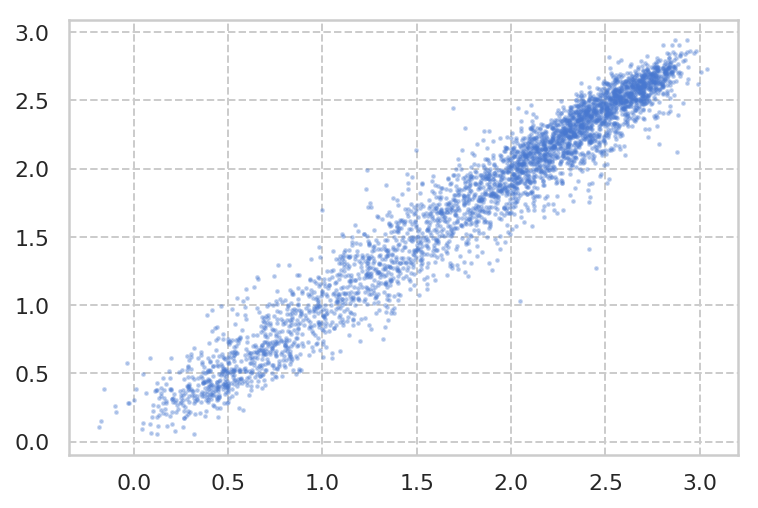

In [224]:
plt.scatter(oof_pred_lgb, oof_pred_xgb, alpha=0.3, s=2)

In [225]:
class DistAdjuster():
    def __init__(self, target):
        dist = Counter(target)
        for k in dist:
            dist[k] /= len(target)

        print("[dist]")
        print(dist)
        self.dist = dist
    
    def adjust(self, pred):
        acum = 0
        self.bound = {}
        for i in range(3):
            acum += self.dist[i]
            self.bound[i] = np.percentile(pred, acum * 100)
        print(self.bound)
        
    def classify(self, x):
        if x <= self.bound[0]:
            return 0
        elif x <= self.bound[1]:
            return 1
        elif x <= self.bound[2]:
            return 2
        else:
            return 3
        
    def fit(self, pred):
        return np.array(list(map(self.classify, pred)))

In [226]:
###################################
da = DistAdjuster(y.iloc[last_gs_idx])
p = best_thresh
pred_blending = np.sum([oof_pred_lgb*p, oof_pred_xgb*(1-p)], axis=0)
da.adjust(pred_blending)
pred_blending_mod = da.fit(pred_blending)

[dist]
Counter({3: 0.4507470946319867, 0: 0.28306585500830106, 1: 0.13724405091311567, 2: 0.12894299944659657})
{0: 1.3787691341274075, 1: 1.861956490102155, 2: 2.1307196448548202}


In [227]:
###################################
score = cohen_kappa_score(pred_blending_mod, y.iloc[last_gs_idx], weights='quadratic')
print(f"seed ave: qwk score = {score}")

seed ave: qwk score = 0.5479716375600661


0    1023
1     496
2     466
3    1629
dtype: int64

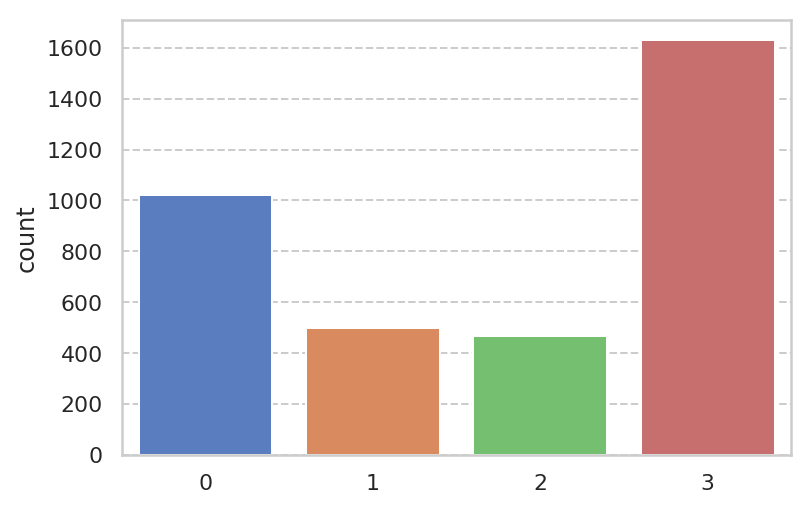

In [228]:
sns.countplot(pred_blending_mod)
pd.Series(pred_blending_mod).value_counts().sort_index()

In [229]:
###################################
da = DistAdjuster(y.iloc[last_gs_idx])
p = best_thresh
pred_blending_test = np.sum([y_pred_test_lgb*p, y_pred_test_xgb*(1-p)], axis=0)
da.adjust(pred_blending_test)
pred_blending_test_mod = da.fit(pred_blending_test)

[dist]
Counter({3: 0.4507470946319867, 0: 0.28306585500830106, 1: 0.13724405091311567, 2: 0.12894299944659657})
{0: 1.6016784434509437, 1: 1.9371815969401975, 2: 2.1503631842299185}


0    283
1    137
2    129
3    451
dtype: int64

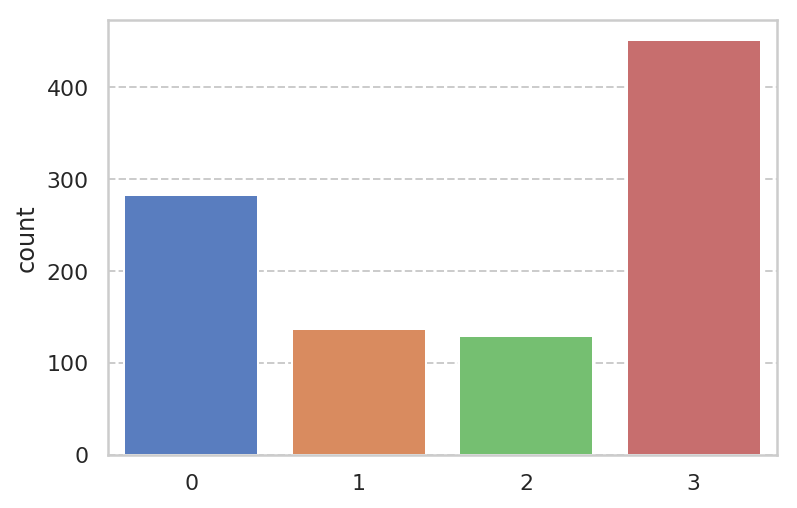

In [230]:
sns.countplot(pred_blending_test_mod)
pd.Series(pred_blending_test_mod).value_counts().sort_index()

In [231]:
submission = pd.read_csv(INPUT_PATH/'sample_submission.csv')
submission['accuracy_group'] = pred_blending_test_mod
submission.to_csv(SUBMIT_PATH/'submission.csv', index=None)
submission.head()


,installation_id,accuracy_group
0,00abaee7,3
1,01242218,3
2,017c5718,3
3,01a44906,3
4,01bc6cb6,2
